In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [56]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [57]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [58]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [59]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

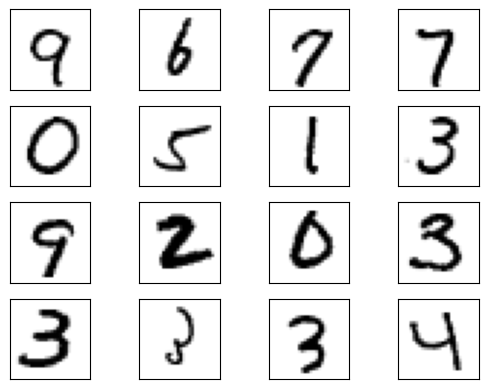

In [60]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [61]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [63]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

generator_loss_per_epoch = []
discriminator_loss_per_epoch = []

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [64]:
counter = 0
torch.manual_seed(111)
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            discriminator_loss_per_epoch.append(loss_discriminator.item())
            generator_loss_per_epoch.append(loss_generator.item())
            with torch.no_grad():
                test_z =  Variable(torch.randn(batch_size, 100).to(device=device))
                generated = generator(test_z)
                counter+=1
                if epoch%10==0 :
                    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' +str(counter)+ '.png')

Epoch: 0 Loss D.: 0.5157378315925598
Epoch: 0 Loss G.: 0.5733115077018738
Epoch: 1 Loss D.: 0.014033865183591843
Epoch: 1 Loss G.: 6.663750648498535
Epoch: 2 Loss D.: 0.1986341029405594
Epoch: 2 Loss G.: 6.632316589355469
Epoch: 3 Loss D.: 0.015729257836937904
Epoch: 3 Loss G.: 11.81342601776123
Epoch: 4 Loss D.: 0.16059336066246033
Epoch: 4 Loss G.: 10.051328659057617
Epoch: 5 Loss D.: 0.1836220920085907
Epoch: 5 Loss G.: 4.8531036376953125
Epoch: 6 Loss D.: 0.1156679093837738
Epoch: 6 Loss G.: 3.186840772628784
Epoch: 7 Loss D.: 0.22694995999336243
Epoch: 7 Loss G.: 3.453092098236084
Epoch: 8 Loss D.: 0.18521441519260406
Epoch: 8 Loss G.: 2.6706345081329346
Epoch: 9 Loss D.: 0.21683043241500854
Epoch: 9 Loss G.: 2.8708810806274414
Epoch: 10 Loss D.: 0.4325826168060303
Epoch: 10 Loss G.: 1.6748230457305908
Epoch: 11 Loss D.: 0.30222031474113464
Epoch: 11 Loss G.: 2.0885372161865234
Epoch: 12 Loss D.: 0.364391028881073
Epoch: 12 Loss G.: 1.7530781030654907
Epoch: 13 Loss D.: 0.40620118

: 

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

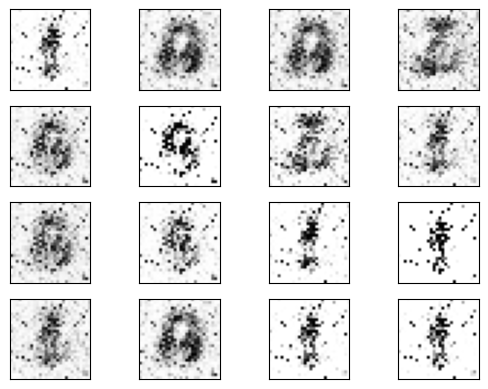

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

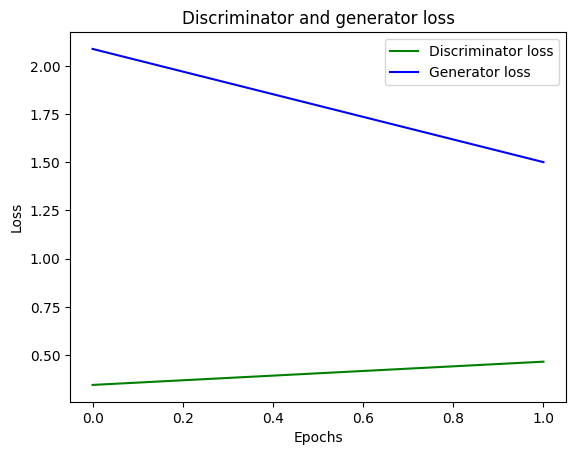

In [ ]:
epochs = range(0,2)
plt.plot(epochs, discriminator_loss_per_epoch, 'g', label='Discriminator loss')
plt.plot(epochs, generator_loss_per_epoch, 'b', label='Generator loss')
plt.title('Discriminator and generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()